Import the necessary libraries.

In [1]:
import csv
import numpy as np
from numpy import dot
from numpy.linalg import norm
from sklearn.feature_extraction.text import TfidfVectorizer
from create_input_lists import create_input_lists_from_csv, lemmatize
from statistics import mean
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from statistics import mean, median, mode
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans
from collections import defaultdict, Counter
from sklearn.metrics import silhouette_score

Obtain and pre-process the texts.

In [2]:
paragraph_path = './OneDrive-2020-12-04/intro_bio (with periods)_labelled/paragraphs.csv'
assessment_path = './OneDrive-2020-12-04/intro_bio (with periods)_labelled/assessments.csv'

In [3]:
para_ids, lemm_para, orig_para, assess_ids, lemma_assess, orig_assess = create_input_lists_from_csv(paragraph_path, assessment_path)

Obtain the TF-IDF vectorization of the texts.

In [4]:
vectorizer = TfidfVectorizer(use_idf=True, stop_words = 'english')
para_vectors = vectorizer.fit_transform(lemm_para)
assess_vectors = vectorizer.fit_transform(lemma_assess)

second_para_vectors = cosine_similarity(para_vectors, para_vectors)
second_assess_vectors = cosine_similarity(assess_vectors, assess_vectors)

In [5]:
print(para_vectors.shape)
print(assess_vectors.shape)
print('\n')
print(second_para_vectors.shape)
print(second_assess_vectors.shape)

(1608, 4121)
(1095, 2630)


In [6]:
para_nonzero_counts = []
for vector in para_vectors:
    para_nonzero_counts.append(vector.count_nonzero())

assess_nonzero_counts = []
for vector in assess_vectors:
    assess_nonzero_counts.append(vector.count_nonzero())
    
second_para_nonzero_counts = []
for vector in second_para_vectors:
    second_para_nonzero_counts.append(vector.count_nonzero())

second_assess_nonzero_counts = []
for vector in second_assess_vectors:
    second_assess_nonzero_counts.append(vector.count_nonzero())

Output Summary Statistics of Vectorizations:

In [7]:
print('TF-IDF for Paragraphs:\n')
print('Average Number of Non-Zeros (First):', mean(para_nonzero_counts))
print('Total # of Dimensions (First):', para_vectors.shape[1])
print('Average Number of Non-Zeros (Second):', mean(second_para_nonzero_counts))
print('Total # of Dimensions (Second):', second_para_vectors.shape[1])

print('\n\nTF-IDF for Assessments:\n')
print('Average Number of Non-Zeros (First):', mean(assess_nonzero_counts))
print('Total # of Dimensions (First):', assess_vectors.shape[1])
print('Average Number of Non-Zeros (Second):', mean(second_assess_nonzero_counts))
print('Total # of Dimensions (Second):', second_assess_vectors.shape[1])

TF-IDF for Paragraphs:

Average Number of Non-Zeros: 20.018034825870647
Total # of Dimensions: 4121


TF-IDF for Assessments:

Average Number of Non-Zeros: 14.107762557077626
Total # of Dimensions: 2630


In [8]:
def plot_distances(distances_list_within, distances_list_between):
    plt.hist(distances_list_within, rwidth = 0.8, bins=np.arange(min(distances_list_within), max(distances_list_within) + 0.01, 0.01), label='Within Cluster Pairs')
    plt.hist(distances_list_within, rwidth = 0.8, bins=np.arange(min(distances_list_within), max(distances_list_within) + 0.01, 0.01), label='Between Cluster Pairs')
    plt.xlabel('Pairwise Distance',fontsize=10)
    plt.ylabel('Frequency',fontsize=10)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.xticks(np.arange(min(distances_list), max(distances_list)+0.1, 0.1))
    plt.legend()
    plt.grid()
    plt.show()
    
def calculate_pairwise_metrics(pairs):    
    cos_sim_list = []
    dist_list = []
    orthogonal_count = 0
    for pair in pairs:
        a,b = pair
        a = np.array(a)
        b = np.array(b)
        cos_sim = dot(a, b)/(norm(a)*norm(b))
        cos_sim_list.append(cos_sim)

        if cos_sim == 0:
            orthogonal_count += 1

        dist = norm(a - b)
        dist_list.append(dist)
    
    return(cos_sim_list, orthogonal_count, dist_list)

    
def print_distance_statistics(dist_list):
    dist_list = [x for x in dist_list if math.isnan(x) == False]
    print('Euclidean Distance Mean:', mean(dist_list))
    print('Euclidean Distance Median:', median(dist_list))
    print('Euclidean Distance Mode:', mode(dist_list))
    print('Euclidean Distance Min:', min(dist_list))
    print('Euclidean Distance Max:', max(dist_list))

In [35]:
km = KMeans(n_clusters = 200, max_iter = 50000, init = 'k-means++')
cluster_assignment = km.fit(assess_vectors).labels_
s = silhouette_score(assess_vectors, cluster_assignment, metric='euclidean')
print(s)

km_second = KMeans(n_clusters = 200, max_iter = 50000, init = 'k-means++')
cluster_assignment_second = km_second.fit(second_assess_vectors).labels_
s_second = silhouette_score(second_assess_vectors, cluster_assignment, metric='euclidean')
print(s_second)

0.10879960415421469


In [36]:
clusterIndex_to_clusteredText1 = defaultdict(lambda: " ")
text_id1_to_clusterIndex = dict()

for i, clusterIndex in enumerate(cluster_assignment): # len(cluster_assignment) is equal to len(vectors)
    clusterIndex_to_clusteredText1[clusterIndex] += orig_assess[i] + ". " 
    text_id1_to_clusterIndex[assess_ids[i]] = clusterIndex

Cosine Similarity Mean: 0.017778784302364445
Cosine Similarity Median: 0.0
Cosine Similarity Mode: 0.0
Cosine Similarity Min: 0.0
Cosine Similarity Max: 0.8496707999000419

Number of Pairs: 595644
Number of Orthogonal Pairs: 437561
Percentage of Orthogonal Pairs: 0.7346015405174903


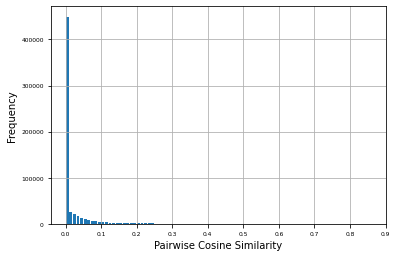

Euclidean Distance Mean: 1.4011054754007257
Euclidean Distance Median: 1.4142135623730951
Euclidean Distance Mode: 1.4142135623730951
Euclidean Distance Min: 0.5483232625011603
Euclidean Distance Max: 1.4142135623730954


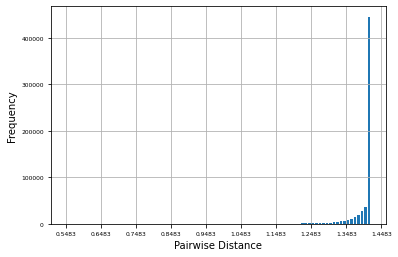

In [37]:
assess_pair_ids = [[a, b] for idx, a in enumerate(assess_ids) for b in assess_ids[idx + 1:]]

inter_cluster_pairs = []
for index in range(0,len(assess_pairs)):
    a, b = assess_pairs[index]
    a_id, b_id = assess_pair_ids[index]
    a_cluster = text_id1_to_clusterIndex[a_id]
    b_cluster = text_id1_to_clusterIndex[b_id]
    if a_cluster != b_cluster:
        inter_cluster_pairs.append([a,b])
    
cluster_sim_list, cluster_count, cluster_dist_list = calculate_pairwise_metrics(inter_cluster_pairs)
print_similarity_statistics(cluster_sim_list)
print('\nNumber of Pairs:', len(inter_cluster_pairs))
print('Number of Orthogonal Pairs:', cluster_count)
print('Percentage of Orthogonal Pairs:', cluster_count/len(inter_cluster_pairs))
plot_similarities(cluster_sim_list)

print_distance_statistics(cluster_dist_list)
plot_distances(cluster_dist_list)

assess_pair_ids = [[a, b] for idx, a in enumerate(assess_ids) for b in assess_ids[idx + 1:]]

intra_cluster_pairs = []
for index in range(0,len(assess_pairs)):
    a, b = assess_pairs[index]
    a_id, b_id = assess_pair_ids[index]
    a_cluster = text_id1_to_clusterIndex[a_id]
    b_cluster = text_id1_to_clusterIndex[b_id]
    if a_cluster == b_cluster:
        intra_cluster_pairs.append([a,b])
    
cluster_sim_list, cluster_count, cluster_dist_list = calculate_pairwise_metrics(intra_cluster_pairs)
print_similarity_statistics(cluster_sim_list)
print('\nNumber of Pairs:', len(intra_cluster_pairs))
print('Number of Orthogonal Pairs:', cluster_count)
print('Percentage of Orthogonal Pairs:', cluster_count/len(intra_cluster_pairs))
plot_similarities(cluster_sim_list)

print_distance_statistics(cluster_dist_list)
plot_distances(cluster_dist_list)